In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import hvplot.pandas
from pyalgotrade import strategy
from pyalgotrade.barfeed import yahoofeed
from pyalgotrade.technical import ma

In [2]:
# Suppressing warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
#Getting BTC Dataframe

# Define the ticker symbol for Bitcoin
btc_symbol = "BTC-USD"

# Specify the date range for the past 10 years
start_date = "2013-10-09"
end_date = "2023-12-04"

# Use yfinance to get Bitcoin data for the specified date range
btc_data = yf.download(btc_symbol, start=start_date, end=end_date, progress=False)

# Extract the "Close" column and create a DataFrame
btc_df = btc_data[["Close"]]

# Print the first few rows of the DataFrame
print(btc_df.head())
print(btc_df.tail())

                 Close
Date                  
2014-09-17  457.334015
2014-09-18  424.440002
2014-09-19  394.795990
2014-09-20  408.903992
2014-09-21  398.821014
                   Close
Date                    
2023-11-29  37858.492188
2023-11-30  37712.746094
2023-12-01  38688.750000
2023-12-02  39476.332031
2023-12-03  39978.390625


In [4]:
# Plot the closing prices for Bitcoin
btc_df.hvplot.line(
    title="Bitcoin Closing Prices",
    xlabel="Date",
    ylabel="Closing Price ($)",
    width=1000,
    height=400,
)



:Curve   [Date]   (Close)

In [5]:
# Preprocessing Data
bitcoin_data = btc_df.copy()
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.head()

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014


In [6]:
# Show last five rows
bitcoin_data.tail()

,Close
Date,
2023-11-29,37858.492188
2023-11-30,37712.746094
2023-12-01,38688.750000
2023-12-02,39476.332031
2023-12-03,39978.390625


In [7]:
# Normalizing BTC Data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(btc_df["Close"].values.reshape(-1, 1))

In [8]:
# Prepare the data for LSTM
def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i : (i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X, y = create_dataset(scaled_data, time_step)

In [9]:
# Reshape the data
X = X.reshape((X.shape[0], X.shape[1], 1))

In [10]:
# Spit the data into training and testing
train_size = int(len(y) * 0.80)
test_size = len(scaled_data) - train_size
train_data, test_data = X[0:train_size, :], X[train_size : len(scaled_data), :]

In [11]:
# Reshape into X_train and y_train
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [12]:
# Building the LSTM Model
model = Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=30))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=10, batch_size=32) #Change epochs to 100 for better results


# Summarize the model
model.summary()

Epoch 1/10
79/79 [==============================] - 3s 19ms/step - loss: 0.0159
Epoch 2/10
79/79 [==============================] - 1s 19ms/step - loss: 7.9856e-04
Epoch 3/10
79/79 [==============================] - 1s 19ms/step - loss: 7.4000e-04
Epoch 4/10
79/79 [==============================] - 1s 19ms/step - loss: 6.4342e-04
Epoch 5/10
79/79 [==============================] - 1s 18ms/step - loss: 6.3013e-04
Epoch 6/10
79/79 [==============================] - 1s 19ms/step - loss: 5.7618e-04
Epoch 7/10
79/79 [==============================] - 2s 19ms/step - loss: 4.8758e-04
Epoch 8/10
79/79 [==============================] - 2s 22ms/step - loss: 4.9766e-04
Epoch 9/10
79/79 [==============================] - 2s 22ms/step - loss: 4.4377e-04
Epoch 10/10
79/79 [==============================] - 2s 22ms/step - loss: 5.1961e-04
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM

In [13]:
# Predicting BTC Prices
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted)

18/18 [==============================] - 0s 7ms/step


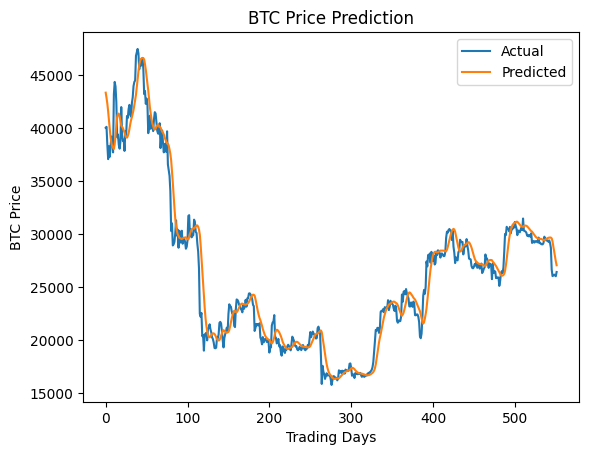

In [14]:
# Visualize the predicted prices
plt.plot(scaler.inverse_transform(y_test.reshape(-1, 1)))
plt.plot(predicted_prices)
plt.title("BTC Price Prediction")
plt.xlabel("Trading Days")
plt.ylabel("BTC Price")
plt.legend(["Actual", "Predicted"])
plt.show()


In [15]:
# Evaluating the Model
from sklearn.metrics import mean_squared_error
from math import sqrt

In [16]:
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y"
mse = mean_squared_error(y_test, predicted)
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 0.0005315866196268715


In [17]:
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 0.0230561622918228


In [18]:
# Predicting Future BTC Prices
# Use the last 100 days of data from the original dataframe
last_100_days = btc_df["Close"][-100:].values.reshape(-1, 1)


In [19]:
# Scale the data to be values between 0 and 1
last_100_days_scaled = scaler.transform(last_100_days)

# Create an empty list
X_test = []

# Append the past 100 days
X_test.append(last_100_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Get the predicted scaled price
pred_price = model.predict(X_test)

1/1 [==============================] - 0s 17ms/step


In [20]:
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(f"Predicted BTC Price: ${pred_price[0][0]}")


Predicted BTC Price: $38568.63671875


In [21]:
# Applying Moving Averages (MA) strategy and backtesting
# Create a new empty DataFrame called `signals`
signals_df = pd.DataFrame(index=btc_df.index)

In [22]:
# Set the `signals` DataFrame with a `signal` column of just zeros
signals_df["Signal"] = 0.0

# Set the short window and long windows
short_window = 50
long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
signals_df["SMA50"] = btc_df["Close"].rolling(window=short_window).mean()
signals_df["SMA100"] = btc_df["Close"].rolling(window=long_window).mean()
signals_df["Signal"][short_window:] = np.where(
    signals_df["SMA50"][short_window:] > signals_df["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_df["Entry/Exit"] = signals_df["Signal"].diff()

# Print the DataFrame
print(signals_df)

            Signal         SMA50        SMA100  Entry/Exit
Date                                                      
2014-09-17     0.0           NaN           NaN         NaN
2014-09-18     0.0           NaN           NaN         0.0
2014-09-19     0.0           NaN           NaN         0.0
2014-09-20     0.0           NaN           NaN         0.0
2014-09-21     0.0           NaN           NaN         0.0
...            ...           ...           ...         ...
2023-11-29     1.0  34112.398086  30356.228164         0.0
2023-11-30     1.0  34329.186602  30473.039062         0.0
2023-12-01     1.0  34567.825625  30595.610156         0.0
2023-12-02     1.0  34820.104766  30728.749746         0.0
2023-12-03     1.0  35082.438438  30868.056973         0.0

[3365 rows x 4 columns]


In [23]:
# Visualize exit position relative to close price
exit = signals_df[signals_df["Entry/Exit"] == -1.0]["SMA100"].hvplot.scatter(
    color="red", legend=False, ylabel="Price in $", width=1000, height=400
)

# Visualize entry position relative to close price
entry = signals_df[signals_df["Entry/Exit"] == 1.0]["SMA100"].hvplot.scatter(
    color="green", legend=False, ylabel="Price in $", width=1000, height=400
)

# Visualize close price for the investment
security_close = btc_df["Close"].hvplot(
    line_color="lightgray",
    ylabel="Price in $",
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = signals_df[["SMA50", "SMA100"]].hvplot(
    ylabel="Price in $",
    width=1000,
    height=400
)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.Close       :Curve   [Date]   (Close)
   .NdOverlay.I       :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.SMA100.I  :Scatter   [Date]   (SMA100)
   .Scatter.SMA100.II :Scatter   [Date]   (SMA100)

In [29]:
# Backtesting the Strategy with PyAlgoTrade
class DualMovingAverageStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, sma_short, sma_long):
        super(DualMovingAverageStrategy, self).__init__(feed, 1000)
        self.__instrument = instrument
        self.__sma_short = sma_short
        self.__sma_long = sma_long
        self.__position = None

    def on_enter_canceled(self, position):
        self.__position = None

    def on_exit_ok(self, position):
        self.__position = None

    def on_exit_canceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # Wait for enough bars to be available to calculate a SMA.
        if self.__sma_long[-1] is None:
            return

        bar = bars[self.__instrument]
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if self.__sma_short[-1] > self.__sma_long[-1]:
                # Enter a buy market order for 10 shares. The order is good till canceled.
                self.__position = self.enterLong(self.__instrument, 10, True)
        # Check if we have to exit the position.
        elif self.__sma_short[-1] < self.__sma_long[-1] and not self.__position.exitActive():
            self.__position.exitMarket()

KeyError: 'entry/exit'

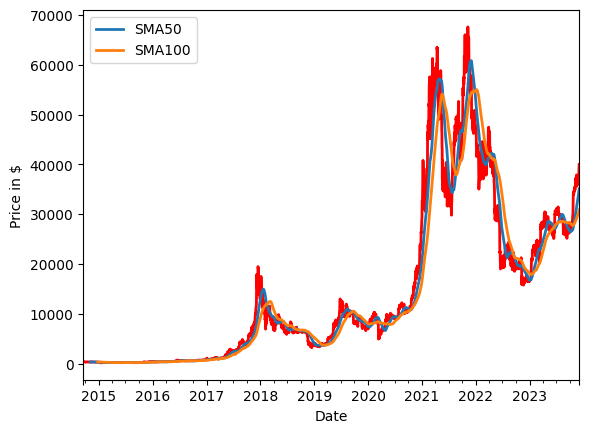

In [30]:
# Applying the backtesting strategy
# Create a figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111, ylabel='Price in $')

# Plot the closing price
btc_df['Close'].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals_df[['SMA50', 'SMA100']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals_df.loc[signals_df['entry/exit'] == 1.0].index,
         signals_df['SMA50'][signals_df['entry/exit'] == 1.0],
         '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals_df.loc[signals_df['entry/exit'] == -1.0].index,
         signals_df['SMA50'][signals_df['entry/exit'] == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()
signals_df[['SMA50', 'SMA100']].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals_df.loc[signals_df.entry/exit == 1.0].index,
         signals_df.SMA50[signals_df.entry/exit == 1.0],
         '^', markersize=10, color='m')

# Plot the sell signals
ax1.plot(signals_df.loc[signals_df.entry/exit == -1.0].index,
         signals_df.SMA50[signals_df.entry/exit == -1.0],
         'v', markersize=10, color='k')

# Show the plot
plt.show()

In [24]:
# Backtesting the Strategy
class SMACrossOver(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, sma_short, sma_long):
        super(SMACrossOver, self).__init__(feed, 1000)
        self.__instrument = instrument
        self.__position = None
        self.__sma_short = sma_short
        self.__sma_long = sma_long
        self.getBroker().setCommission(strategy.backtesting.TradePercentage(0.001))

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        # Wait for enough bars to be available to calculate a SMA.
        if self.__sma_long[-1] is None:
            return

        bar = bars[self.__instrument]
        # If a position was not opened, check if we should enter a long position.
        if self.__position is None:
            if self.__sma_short[-1] > self.__sma_long[-1]:
                # Enter a buy market order for 10 BTC. The order is good till canceled.
                self.__position = self.enterLong(self.__instrument, 10, True)
        # Check if we have to exit the position.
        elif self.__sma_short[-1] < self.__sma_long[-1] and not self.__position.exitActive():
            self.__position.exitMarket()
